# Calibration analysis

In [1]:
import sys

sys.path.append('../')
from utils import settings
from utils.helper import ensure_list

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

from itertools import product

In [2]:
%config InlineBackend.figure_format='retina'

new_rc_params = {
    "text.usetex": False,
    "svg.fonttype": 'none',
    "font.size": 7,
}
plt.rcParams.update(new_rc_params)

In [3]:
model_names = settings.MODEL_TITLE_NAMES
model_colors = settings.MODEL_COLORS

In [4]:
N_SNPS_TESTED = settings.N_SNPS

def load_results(gvar, model, ntested):
    ncontexts = settings.NUM_CONTEXTS_DEFAULT
    f = f'../results/simulated/gvar~{gvar}_fevgxc~0.0_ncontexts~{ncontexts}_model~{model}_context~mofa_ntested~{ntested}_pvals.txt'
    return pd.read_csv(f, index_col=0, header=None, names=['gene'] + [f'var{i}' for i in range(N_SNPS_TESTED)])

def get_pvals(df, threshold=0.01):
    return df['var0'] * N_SNPS_TESTED

def qqplot(data, **kws):
    (osm, osr), _ = probplot(data, dist='uniform')
    ax = plt.gca()
    df = pd.DataFrame({'osm': -np.log10(osm), 'osr': -np.log10(osr)})
    sns.scatterplot(x='osm', y='osr', data=df, ax=ax, edgecolor=None, **kws)
    m = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([0, m], [0, m], c='lightgrey', linestyle=':')
    ax.set(xlabel=r'Expected $-\log_{10} P$', ylabel=r'Observed $-\log_{10} P$')
    
def create_df(gvar, model, ntested):
    df = pd.DataFrame()

    for g, m, nt in product(gvar, model, ntested):
        try:
            pvals = get_pvals(load_results(gvar=g, model=m, ntested=nt))
        except FileNotFoundError:
            continue        
        new_entry = pd.DataFrame({'gvar': g, 'model': model_names[m], 'ntested': nt, 'pvals': pvals})
        df = pd.concat([df, new_entry], axis=0)
    return df.reset_index(drop=True)

## Interaction tests

In [5]:
gvar=ensure_list(settings.GENETIC_VAR) + [0.0]
model=['cellregmap', 'cellregmap-fixed-single-env', 'cellregmap-fixed-multi-env', 'structlmm']
ntested=[settings.NUM_TESTED_DEFAULT, settings.NUM_TESTED[-1]]

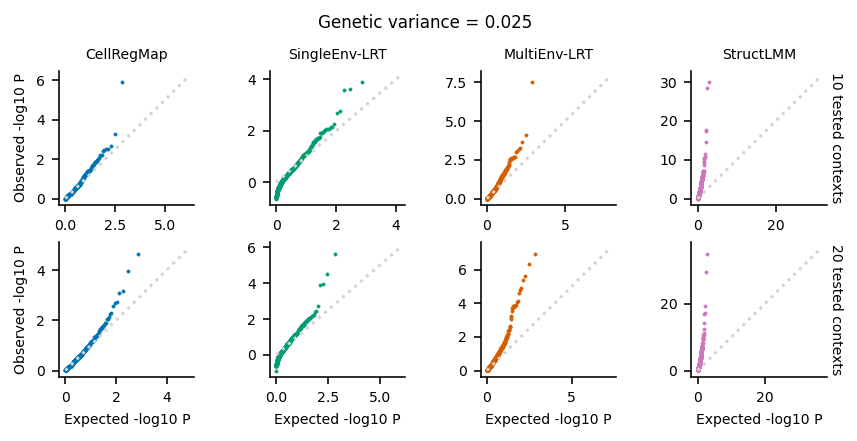

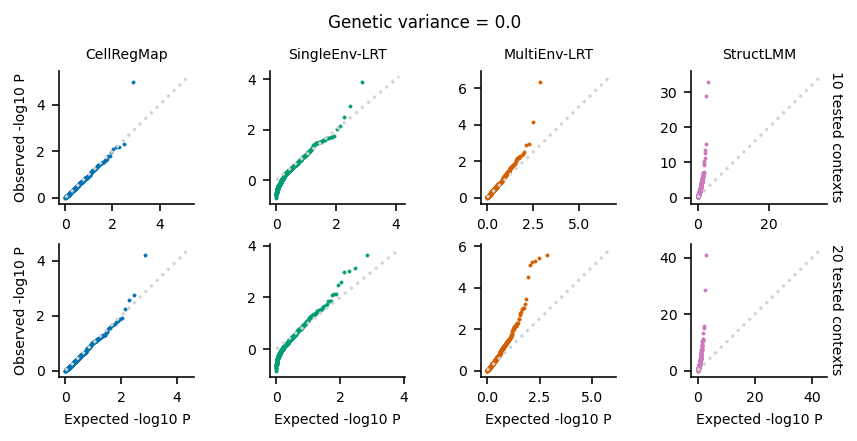

In [6]:
df = create_df(gvar=gvar, model=model, ntested=ntested)

for gv in df['gvar'].unique():
    g = sns.FacetGrid(
        data=df.query('gvar == @gv'), 
        row='ntested', 
        col='model', 
        hue='model', 
        sharey=False,
        sharex=False,
        margin_titles=True,
        height=1.5,
        aspect=1,
        palette=model_colors).map(qqplot, 'pvals', s=3, rasterized=True)
    g.set_titles(
        col_template="{col_name}", 
        row_template="{row_name} tested contexts")
    g.set_axis_labels('Expected -log10 P', 'Observed -log10 P')
    g.fig.suptitle(f'Genetic variance = {gv}')
    g.fig.subplots_adjust(top=.85)
    plt.savefig(f"figures/calibration_interaction_gvar~{gv}.svg", dpi=300)

## Association tests

In [7]:
gvar=[0.0]
model=['cellregmap-association']
ntested=[settings.NUM_TESTED_DEFAULT]

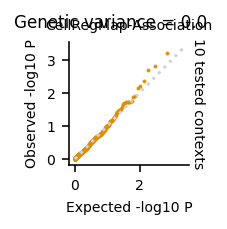

In [8]:
df = create_df(gvar=gvar, model=model, ntested=ntested)

for gv in df['gvar'].unique():
    g = sns.FacetGrid(
        data=df.query('gvar == @gv'), 
        row='ntested', 
        col='model', 
        hue='model', 
        sharey=False,
        sharex=False,
        margin_titles=True,
        height=1.5,
        aspect=1,
        palette=model_colors).map(qqplot, 'pvals', s=3, rasterized=True)
    g.set_titles(
        col_template="{col_name}", 
        row_template="{row_name} tested contexts")
    g.set_axis_labels('Expected -log10 P', 'Observed -log10 P')
    g.fig.suptitle(f'Genetic variance = {gv}')
    g.fig.subplots_adjust(top=.85)
    plt.savefig(f"figures/calibration_association_gvar~{gv}.svg", dpi=300)

## (For main figure)

In [9]:
gvar=[0.0]
model=['cellregmap', 'structlmm', 'cellregmap-association']
ntested=[settings.NUM_TESTED_DEFAULT]

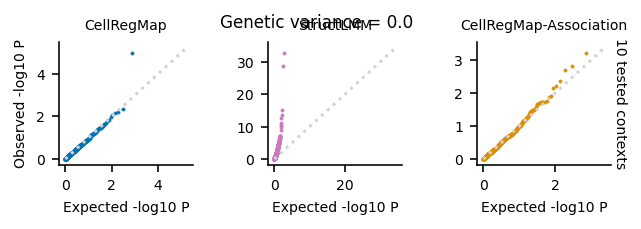

In [10]:
df = create_df(gvar=gvar, model=model, ntested=ntested)

g = sns.FacetGrid(
    data=df.query('gvar == @gv'), 
    row='ntested', 
    col='model', 
    hue='model', 
    sharey=False,
    sharex=False,
    margin_titles=True,
    height=1.5,
    aspect=1,
    palette=model_colors).map(qqplot, 'pvals', s=3, rasterized=True)
g.set_titles(
    col_template="{col_name}", 
    row_template="{row_name} tested contexts")
g.set_axis_labels('Expected -log10 P', 'Observed -log10 P')
g.fig.suptitle(f'Genetic variance = {gv}')
g.fig.subplots_adjust(top=.85)
plt.savefig(f"figures/calibration_main.svg", dpi=300)